# Dike Malicious - Static Approach

# Laporan CRISP-DM

## Business Understanding 
Sistem Pendeteksi Virus pada suatu perangkat lunak diperlukan karena :
- Perusahaan menghadapi risiko besar dari serangan malware yang dapat mencuri data, merusak sistem, atau menghentikan operasional.
- Serangan malware bisa menyebabkan kerugian finansial besar, seperti kehilangan data pelanggan, kerusakan sistem, dan denda kepatuhan.
- Perusahaan yang bisa menjamin keamanan data punya nilai jual lebih tinggi dibanding kompetitor.

## Data Understanding

Dataset yang digunakan adalah DikeDataset https://github.com/iosifache/DikeDataset , sebuah koleksi file executable (.exe) dengan rentang tahun 2018-2021 yang dapat dikelompokkan menjadi dua kategori utama:

Benign: File executable yang tidak berbahaya.
Malicious: File executable yang berisi malware (berbahaya).

File-file ini merupakan representasi realistis dari program Windows, yang biasanya menjadi target utama serangan malware.
Keunikan dari file .exe ialah, metadata file tersebut dapat diekstrak dan memungkinkan untuk menganalisis pola tertentu pada masing-masing bagian metadata.
Untuk mendukung proses tersebut, digunakanlah 'pefile' sebagai feature extractor pada masing-masing .exe file yang dapat diunduh melalui !pip install pefile.

### Distribusi Kelas
DikeDataset mengandung distribusi sebagai berikut :
1. Benign (aman) sebanyak 1083 data
2. Malware sebanyak 10842

Dikarenakan klasifikasi hanya berdasarkan struktur file .exe, maka hanya akan diambil file exe saja dengan distribusi :
1. Benign sebanyak 962 data
2. Malware sebanyak 8970 data

## Data Preprocessing

### Imbalance Preprocessing
Ketidakseimbangan distribusi kelas tersebut, tentu akan berpengaruh pada hasil prediksi model. Oleh sebab itu, penulis menggunakan Random Undersampling pada kelas Malware dengan ketentuan :
1. Menggunakan semua data malware dengan tingkat label malicious <=0.7
2. Random sampling hingga data mencapai 962 data pada data dengan malicious > 0.7

### Proses Ekstraksi Fitur
Menggunakan PEFILE, dilakukan parsing terhadap struktur PE dari masing-masing file untuk mengambil fitur-fitur statis tanpa perlu mengeksekusi file secara langsung (static analysis). Fitur-fitur umum yang diekstrak antara lain:

 DOS Header
PE file selalu diawali oleh struktur DOS header, dan beberapa nilai di dalamnya dapat mengindikasikan karakteristik awal dari executable. Fitur-fitur yang diambil meliputi:

'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc','e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc','e_ovno', 'e_oemid', 'e_oeminfo', 'e_lfanew'

Total: 17 fitur

2. File Header
Bagian ini mengandung informasi dasar tentang file PE, seperti jumlah section dan karakteristik umum file biner:

Contoh: 'Machine', 'NumberOfSections', 'TimeDateStamp','PointerToSymbolTable', 'NumberOfSymbols','SizeOfOptionalHeader', 'Characteristics'

Total: 7 fitur

3. Optional Header
Berisi informasi penting seperti ukuran kode, alamat entry point, ukuran heap/stack, dan versi sistem yang ditargetkan. Fitur-fitur ini sering kali menjadi indikator baik dari perilaku normal maupun berbahaya:

Contoh: 'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion','SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment','FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion','MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion','MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'Subsystem','DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit','SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes'

Total: 30 fitur

4. Image Directory Entries
Terdapat 16 entri direktori pada PE Optional Header, yang masing-masing menunjukkan lokasi dan ukuran tabel penting seperti import, export, resource, dll.

Diekstrak sebagai:

ImageDirectory_0_VirtualAddress, ImageDirectory_0_Size, hingga ImageDirectory_15_*


## Modelling

Random Forest adalah algoritma ensemble berbasis pohon keputusan (Decision Tree) yang membentuk banyak pohon (trees) dan menggabungkan hasilnya melalui voting (untuk klasifikasi).

Alasan Pemilihan Random Forest:
* Robust terhadap overfitting untuk dataset yang tidak terlalu besar.
* Dapat menangani banyak fitur seperti struktur PE yang kompleks (86+ fitur).
* Memberikan feature importance, berguna untuk interpretasi fitur keamanan.
* Mampu menangani nilai numerik dan kategorikal secara bersamaan.
* Cocok untuk dataset dengan distribusi biner seperti malware vs benign.

## Evaluation

1. Akurasi Tinggi pada Data Validasi dari DikeDataset
Model yang dibangun menggunakan DikeDataset menunjukkan hasil yang sangat baik pada data latih dengan akurasi mencapai 0.99 (99%), yang menunjukkan bahwa model mampu mengenali pola pada dataset tersebut dengan sangat baik.

2. Evaluasi pada Dataset Testing Gabungan
Model kemudian diuji pada dataset campuran yang terdiri dari:

* 100 file benign (2021–2025) dari Benign-Net
* 77 malware tahun 2021–2022 dari TheZoo
* 23 malware baru tahun 2025 dari MalwareBazaar

| Kasus Uji                   | Akurasi |
| --------------------------- | ------- |
| Malware 2021–2022 (77 file) | 70%     |
| Malware 2025 (23 file)      | 8%      |
| Benign 2021–2025 (100 file) | 97%     |

3. Evaluasi Keseluruhan (200 Data)
True Positives (TP): 56 (malware terdeteksi benar)
True Negatives (TN): 97 (benign terdeteksi benar)
False Positives (FP): 3 (benign dikira malware)
False Negatives (FN): 44 (malware tidak terdeteksi)

Accuracy = (56 + 97) / 200 = 76.5%
True Positive Rate (TPR) = 56/100 = 56%
True Negative Rate (TNR) = 97/100 = 97%
False Positive Rate (FPR) = 3 / 100 = 3%
False Negative Rate (FNR) = 44 / 100 = 44%

4. Analisis dan Interpretasi
Walaupun model menunjukkan akurasi tinggi saat diuji pada data pelatihan, performa menurun drastis saat diuji pada dataset malware tahun 2025. Hal ini menunjukkan overfitting pada dataset DikeDataset, serta kurangnya generalisasi model terhadap varian malware baru.

* Malware 2021–2022: Masih terdeteksi cukup baik dengan akurasi 70%, kemungkinan karena struktur file masih menyerupai data latih.
* Malware 2025: Hanya 2 dari 23 file yang dikenali sebagai malicious, dengan akurasi sangat rendah yaitu 8%.
* Benign files: Model dapat mengenali file tidak berbahaya dengan sangat baik, terbukti dari TNR sebesar 97% dan FPR hanya 3%.

5. Kesimpulan Evaluasi
Walaupun secara data terdapat ketidakkonsistenan antara hasil pada DikeDataset dan hasil pada dataset testing eksternal, hal ini didorong oleh evolusi malware yang semakin kompleks dari waktu ke waktu. Pola struktur PE yang digunakan oleh malware di tahun-tahun baru mungkin sudah tidak lagi menyerupai data pelatihan, membuat model kesulitan dalam mengenali pola tersebut.

Terlihat pada dataset malware 2025, model hanya mampu mengenali 2 dari 23 data, sedangkan pada malware tahun 2021–2022, model masih dapat mengenali pola dengan akurasi 70%, walaupun hanya berselisih satu tahun dari data latih.
Agar model machine learning untuk deteksi malware tetap efektif, maka model harus diperbarui dan dilatih secara berkala dengan data terbaru.
Ini penting agar model mampu beradaptasi dengan pola baru, teknik obfuscation, dan perubahan struktur internal PE file dari malware generasi baru.

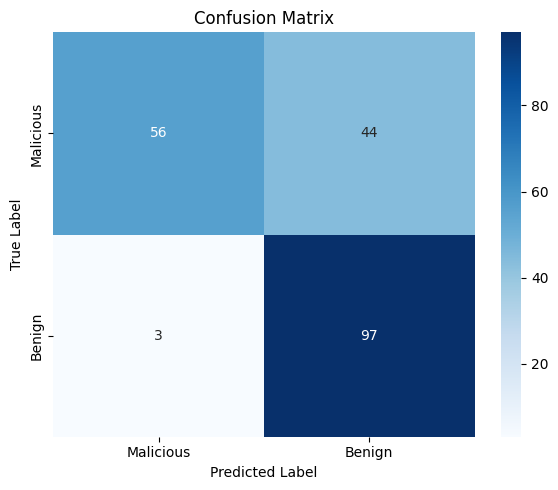

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define values
TP = 56  # True Positive: Malicious correctly predicted
FN = 44  # False Negative: Malicious not detected
FP = 3   # False Positive: Benign wrongly predicted as malicious
TN = 97  # True Negative: Benign correctly predicted

# Confusion matrix as NumPy array
conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

# Labels
labels = ['Malicious', 'Benign']

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Deploy
Keseluruhan aplikasi ini dapat digunakan dengan link berikut https://malicious-dike-software-5j3uiojhggw5gvcknskcz9.streamlit.app/ yang dapat diakses secara daring.
adapun limitasinya ialah hanya menerima .exe dan .dll dengan maksimal 200 MB file

# CODING

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/randomforest-malicious-software/scikitlearn/default/1/random_forest_model.pkl


In [14]:
!git clone --filter=blob:none --sparse https://github.com/InQuest/malware-samples.git
%cd malware-samples
!git sparse-checkout init --cone
!git sparse-checkout set 2019-09-Emotet

Cloning into 'malware-samples'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 319 (delta 88), reused 83 (delta 83), pack-reused 199 (from 1)
Receiving objects: 100% (319/319), 68.27 KiB | 11.38 MiB/s, done.
Resolving deltas: 100% (144/144), done.
remote: Enumerating objects: 2, done.
remote: Total 2 (delta 0), reused 0 (delta 0), pack-reused 2 (from 1)
Receiving objects: 100% (2/2), 3.81 KiB | 3.81 MiB/s, done.
/kaggle/working/malware-samples/malware-samples
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (25/25), 614.18 KiB | 25.59 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [15]:
!pip install pefile

# Langkah Extract Data
1. Ambil data dulu dari !git clone https://github.com/iosifache/DikeDataset.git
2. Install pefile untuk extract .exe file (!pip install pefile)
3. Jalankan kode berikut

In [12]:
import pefile
import pandas as pd
import os

# # Path
# folder_path = "/kaggle/working/DikeDataset/files/benign"
folder_path = "/kaggle/working/malware-samples/2019-09-Emotet"

# List data
all_rows = []

# Ambil semua .exe file
for filename in os.listdir(folder_path):
    if filename.endswith(".exe"):
        filepath = os.path.join(folder_path, filename)
        try:
            pe = pefile.PE(filepath)

            # Extract DOS Header fields
            dos_header_fields = [
                'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc',
                'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc',
                'e_ovno', 'e_oemid', 'e_oeminfo', 'e_lfanew'
            ]
            dos_header = {field: getattr(pe.DOS_HEADER, field) for field in dos_header_fields}

            # Extract File Header fields
            file_header_fields = [
                'Machine', 'NumberOfSections', 'TimeDateStamp',
                'PointerToSymbolTable', 'NumberOfSymbols',
                'SizeOfOptionalHeader', 'Characteristics'
            ]
            file_header = {field: getattr(pe.FILE_HEADER, field) for field in file_header_fields}

            # Extract Optional Header fields
            optional_header_fields = [
                'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion',
                'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
                'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment',
                'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion',
                'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion',
                'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'Subsystem',
                'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit',
                'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes'
            ]
            optional_header = {field: getattr(pe.OPTIONAL_HEADER, field) for field in optional_header_fields}

            # Extract Image Directory entries (all 16)
            image_directory = {}
            for i in range(16):  # There are 16 directories
                entry = pe.OPTIONAL_HEADER.DATA_DIRECTORY[i]
                image_directory[f"ImageDirectory_{i}_VirtualAddress"] = entry.VirtualAddress
                image_directory[f"ImageDirectory_{i}_Size"] = entry.Size

            # Combine all features
            all_features = {'filename': filename}
            all_features.update(dos_header)
            all_features.update(file_header)
            all_features.update(optional_header)
            all_features.update(image_directory)

            # Append to list
            all_rows.append(all_features)

        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

# Convert ke CSV
df = pd.DataFrame(all_rows)
df

""


# Input Data

In [ ]:
## Dari Dike Dataset/labels
df_benign = pd.read_csv('/kaggle/working/DikeDataset/labels/benign.csv')
df_malware = pd.read_csv('/kaggle/working/DikeDataset/labels/malware.csv')

## Extracted Features .csv (File yg di WA)
df_main_benign = pd.read_csv('/kaggle/working/pe_header_features_all_benign.csv')
df_main_malware = pd.read_csv('/kaggle/working/pe_header_features_all_malware.csv')

# Removing the name
df_main_benign.iloc[:, 0] = df_main_benign.iloc[:, 0].str.replace('.exe', '', regex=False)
df_main_malware.iloc[:, 0] = df_main_malware.iloc[:, 0].str.replace('.exe', '', regex=False)

In [ ]:
# Sesuaikan File extract dengan File Features yang ada di 
merged_malware = pd.merge(df_malware, df_main_malware, left_on='hash', right_on='filename', how='inner')
merged_malware

merged_benign = pd.merge(df_benign, df_main_benign, left_on='hash', right_on='filename', how='inner')
merged_benign

## UnderSampling Malicious Malware

In [ ]:
# Buat 10 Bin
bins = [i / 10 for i in range(11)]
labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]

# Kategorisasikan
merged_malware['malice_group'] = pd.cut(merged_malware['malice'], bins=bins, labels=labels, include_lowest=True)

# Step 1: Ambil semua data untuk kelompok Malice <= 0.7 (Sekitar 400 an data). Nilai 0.7 diambil dari Distribusi Data
low_group = merged_malware[merged_malware['malice'] <= 0.7]

# Step 2: Hitung banyak data untuk Kategori malice <=0.7
count_low = len(low_group)

# Step 3: Sisa Data untuk Malice >0.7
n_needed = 962 - count_low

# Step 4: Random Sample untuk Malice >0.7 sebanyak sisa yang ada
high_group = merged_malware[merged_malware['malice'] > 0.7]
sampled_high = high_group.sample(n=n_needed, random_state=42)

# Step 5: Gabungkan kedua data
final_df = pd.concat([low_group, sampled_high], ignore_index=True)

# Optional: Acak data
final_df_malware = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
final_df_malware.drop(columns=['malice_group'], inplace=True)

# Final check
print(f"Total Data: {len(final_df)}")


# Gabungkan Menjadi 1 Dataframe

In [ ]:
df_main = pd.concat([merged_benign,final_df_malware],ignore_index=True)
df_main

# Tambahkan Label Berdasarkan kolom Malice

In [ ]:
df_main['label'] = df_main['malice'].apply(lambda x: 0 if x == 0 else 1)
df_main

# Split Train-Test

In [3]:
# Fitur yang diekstrak dimulai dari Kolom Ke 13 dengan Kolom 1-12 berisi data dari Multilabelling Dike Dataset (Tidak Digunakan untuk Binary Classification)
df_main.info() 

NameError: name 'df_main' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Pilih Fitur
X = df_main.iloc[:, 13:-1]       # Ambil Semua Fitur dari Kolom ke- 13 hingga Sebelum Terakhir (Kolom Terakhir adalah Label)
y = df_main['label']           # Target Berada di kolom Terakhir

# Pembagian data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


# Modelling

In [ ]:
# Library Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Library Save Model
import joblib

#Metrics
from sklearn.metrics import classification_report

# 1. Inisialisasi Model
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 2. Kode Pelatihan
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🧠 Model: {name}")
    print(classification_report(y_test, y_pred))

    # Save model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")


!curl -X POST https://mb-api.abuse.ch/api/v1/ \
     -d "query=get_file" \
     -d "sha256=2cf509961fdf76bdce189a3216b441dca91f858527062699d2ed55487aba80a4" --output sample.zip


# Testing In New Files

In [17]:
import pefile
import pandas as pd
import os

folder_path = "/kaggle/working/malware-samples/2019-09-Emotet"
all_rows = []

def is_pe_file(filepath):
    try:
        with open(filepath, 'rb') as f:
            return f.read(2) == b'MZ'
    except:
        return False

for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)
    
    if not is_pe_file(filepath):
        print(f"Skipping {filename}: Not a PE file (no MZ header)")
        continue

    try:
        pe = pefile.PE(filepath, fast_load=True)

        # Extract DOS Header
        dos_header_fields = [
            'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc',
            'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc',
            'e_ovno', 'e_oemid', 'e_oeminfo', 'e_lfanew'
        ]
        dos_header = {field: getattr(pe.DOS_HEADER, field) for field in dos_header_fields}

        # File Header
        file_header_fields = [
            'Machine', 'NumberOfSections', 'TimeDateStamp',
            'PointerToSymbolTable', 'NumberOfSymbols',
            'SizeOfOptionalHeader', 'Characteristics'
        ]
        file_header = {field: getattr(pe.FILE_HEADER, field) for field in file_header_fields}

        # Optional Header
        optional_header_fields = [
            'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion',
            'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
            'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment',
            'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion',
            'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion',
            'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'Subsystem',
            'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit',
            'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes'
        ]
        optional_header = {field: getattr(pe.OPTIONAL_HEADER, field) for field in optional_header_fields}

        # Image Directory
        image_directory = {}
        for i in range(16):
            entry = pe.OPTIONAL_HEADER.DATA_DIRECTORY[i]
            image_directory[f"ImageDirectory_{i}_VirtualAddress"] = entry.VirtualAddress
            image_directory[f"ImageDirectory_{i}_Size"] = entry.Size

        # Combine
        all_features = {'filename': filename}
        all_features.update(dos_header)
        all_features.update(file_header)
        all_features.update(optional_header)
        all_features.update(image_directory)

        all_rows.append(all_features)

    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

# To DataFrame
df = pd.DataFrame(all_rows)
df.head()


Skipping 80a20cc187063ebfd0d9924d72955f4b0105e13ce7e7cb41619aa49834f5ab26: Not a PE file (no MZ header)
Skipping 5a8c51d22698e05215e2f3fdc50a14342fb3108acf6bde761c87d9ae2106d5d1: Not a PE file (no MZ header)
Skipping 0db5f3b6fc6e6bbff2e1642a400e2633fae39063d2d5bea8c6370f42424907fc: Not a PE file (no MZ header)
Skipping a88780c026c4094e0580a2ab21118b96dab08e00d1935bd6fae2946fd81bdb03: Not a PE file (no MZ header)
Skipping 3e390763b85cd1322e1fe528ab15923df480ce1f2dabff373bfc67ed8d0d5aa7: Not a PE file (no MZ header)
Skipping 8ce63dc6baa9a80c3913d462bdb19fc1bc1ba635bde1d5a6c26fc5f7cf325ea4: Not a PE file (no MZ header)
Skipping c19c5960f37853a5f2db86cc749593dd98b124ddd21d39b8ca53c921389a0bd6: Not a PE file (no MZ header)
Skipping fb8d06fde7d7477c3901566906ab3cab4be434ac505b88b306dc52bcf6cb3db6: Not a PE file (no MZ header)
Skipping d3c733fab28b47b010b46938694b97df9294c12158281d5c6a8069cb4a5a0e2e: Not a PE file (no MZ header)
Skipping 7b6385257f2b06d7f8098f3f3b87b9b141d8869f2419c27028a50c6

""
